## Esse notebook:
** extrai features de uma determinada imagem e salva em CSV o array de features e a label

** Le esse arquivo e prepara no formato pra treinar uma rede neural

** Tem uma etapa de testar manualmente logo abaixo, le uma imagem, extrai features e ve o resultado no modelo treinado

In [197]:
import cv2
import numpy as np
import scipy
#from scipy.misc.pilutil import imread
import pickle
import random
import os
#import matplotlib.pyplot as plt
import scipy.spatial
import pandas as pd

In [367]:
image = cv2.imread('simple-shapes/data/circle0.png')
print(image.shape)
# alg = cv2.ORB_create()
# kps = alg.detect(image,None)
# print(kps)

# alg2 = cv2.KAZE_create()
# kps2 = alg2.detect(image,None)
# print(kps2)

# alg3 = cv2.AKAZE_create()
# kps3 = alg3.detect(image,None)
# print(kps3)

# sift = cv2.xfeatures2d.SIFT_create()
# (kps, descs) = sift.detectAndCompute(image, None)
# print(descs)

(64, 64, 3)


In [363]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = cv2.imread(image_path)

    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install     

        image = cv2.resize(image, (360, 360), interpolation=cv2.INTER_CUBIC)
    
       # Remover ruídos
#         img_equalizada = cv2.equalizeHist(img_redimensionada)
#         image = cv2.GaussianBlur(img_equalizada, (9,9), 1)
        
        
        # KAZE
        alg = cv2.KAZE_create()

        # SIFT
#         alg = cv2.xfeatures2d.SIFT_create()
        
        kps = alg.detect(image, None)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)

        
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]      
 
        # computing descriptors vector
        kps, dsc1 = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc1.flatten()

        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        
#         print(dsc1.size)
   
        
        if dsc1.shape[0] < vector_size: #precisa encher os keypoints que eram zero
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            for i in range(vector_size - dsc1.shape[0]): #numero de features faltantes
                dsc1 = np.append(dsc1, [np.zeros(64)], axis=0)


        
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None
    
    return dsc, dsc1
#resources/

def batch_extractor(images_path):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    
    result = {}
    descritores = []
    labels = []
    
    for f in files:
        print('Extracting features from image %s', f)
        name = f.split('/')[-1].lower()
        try:
            result[name],dsc1 = extract_features(f)
            descritores.append(dsc1)
            print(dsc1.shape)
            labels.append(name[0:4])

        except:
            print('erro no arquivo', f)
            
    resultado_csv=pd.DataFrame(result)
    
    
    
    centroides = PacoteDePalavras()
    descritores = np.array(descritores)
    resultado_2d = descritores.reshape(-1, descritores.shape[-1])
    centroides.gerar_dicionario(resultado_2d)
    DICIONARIO_NOME = 'dicionario.csv'
    centroides.salvar_dicionario('', DICIONARIO_NOME)
    
    histogramas = []
    
    print(len(descritores))
    
    for i in range(len(descritores)):
        histograma_descritor = centroides.histograma_de_frequencia(descritores[i])
        histograma_descritor = np.append(histograma_descritor,labels[i])
        histogramas.append(histograma_descritor)

            
    pd.DataFrame(histogramas).to_csv('histogramas.csv', index = False)
    resultado_csv.to_csv('features2.csv',index=False)
    return result


In [364]:
## ESSE CODIGO NAO TA SENDO USADO AGORA, ERA UM MATCH ENTRE IMAGENS SIMILARES

class Matcher(object):

    def __init__(self, result):
        self.data = result
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        
#         figura = Figura(features)
#         print('Essa figura eh:', figura.categoria)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

In [365]:
# RUN!!!


def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()
    
    
def run():
    
    
    
    images_path = 'simple-shapes/data'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting 3 random images 
    sample = random.sample(files, 4)
    
    result = batch_extractor(images_path)


run()

Extracting features from image %s simple-shapes/data/circle0.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle1.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle10.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle11.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle12.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle13.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle14.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle15.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle16.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle17.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle18.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle19.png
(32, 64)
Extracting features from image %s simple-shapes/data/circle2.png
(32, 64)
Extracting features from ima

(32, 64)
Extracting features from image %s simple-shapes/data/ellipse18.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse19.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse2.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse20.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse21.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse22.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse23.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse24.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse25.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse26.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse27.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse28.png
(32, 64)
Extracting features from image %s simple-shapes/data/ellipse29.png
(32, 64)
Extr

(32, 64)
Extracting features from image %s simple-shapes/data/rectangle26.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle27.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle28.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle29.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle3.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle30.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle31.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle32.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle33.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle34.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle35.png
(32, 64)
Extracting features from image %s simple-shapes/data/rectangle36.png
(32, 64)
Extracting features from image %s simple-shapes/data/rec

(32, 64)
Extracting features from image %s simple-shapes/data/square33.png
(32, 64)
Extracting features from image %s simple-shapes/data/square34.png
(32, 64)
Extracting features from image %s simple-shapes/data/square35.png
(32, 64)
Extracting features from image %s simple-shapes/data/square36.png
(32, 64)
Extracting features from image %s simple-shapes/data/square37.png
(32, 64)
Extracting features from image %s simple-shapes/data/square38.png
(32, 64)
Extracting features from image %s simple-shapes/data/square39.png
(32, 64)
Extracting features from image %s simple-shapes/data/square4.png
(32, 64)
Extracting features from image %s simple-shapes/data/square40.png
(32, 64)
Extracting features from image %s simple-shapes/data/square41.png
(32, 64)
Extracting features from image %s simple-shapes/data/square42.png
(32, 64)
Extracting features from image %s simple-shapes/data/square43.png
(32, 64)
Extracting features from image %s simple-shapes/data/square44.png
(32, 64)
Extracting featur

(32, 64)
Extracting features from image %s simple-shapes/data/triangle42.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle43.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle44.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle45.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle46.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle47.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle48.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle49.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle5.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle50.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle51.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle52.png
(32, 64)
Extracting features from image %s simple-shapes/data/triangle53.png


score:  0.8775


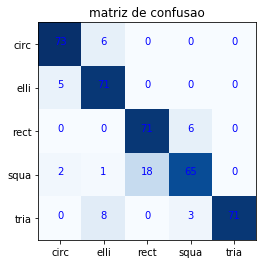

In [368]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

def prepara_dados():
    data = pd.read_csv('features.csv')
    data = pd.read_csv('histogramas.csv')
    
    indice = len(data.columns)-1
#     print(indice)
    
    y = data.iloc[:,indice]
    
    X_=data.iloc[:,0:indice]

#     #y = list(data.columns)
#     for i in range(len(y)):
#         y[i] = y[i][0:4]
#     x = (data.iloc[0::]).T #ele ta salvando de uma maneira que cada X eh uma coluna e a primeira linha eh y

#     X_ = []

    
#     for i in range(x.shape[0]-1):
#         X_.append(list(x.iloc[i]))  
        
    scaler = preprocessing.MinMaxScaler()
    X_ = scaler.fit_transform(X_)

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)

    
    return X_,y,le


def treina_rede(X,y):
    import random
    from sklearn import ensemble
    from sklearn.neural_network import MLPClassifier
    import matplotlib.pyplot as plt          
    
    #x = imagens
    sample_index=random.sample(range(len(x)),int(len(x)/5)) #20-80
    valid_index=[i for i in range(len(x)) if i not in sample_index]

    sample_images=[x[i] for i in sample_index]
    valid_images=[x[i] for i in valid_index]

    #Sample and validation targets
    sample_target=[y[i] for i in sample_index]
    valid_target=[y[i] for i in valid_index]



    #USANDO REDE NEURAL
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(128,512,256,5), random_state=1, max_iter=500000, 
                        learning_rate_init=0.0001, activation='relu')
    clf.fit(sample_images, sample_target)
    print('score: ',clf.score(valid_images, valid_target))  
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    rotulos_previstos = le.inverse_transform(clf.predict(valid_images))
    matriz = confusion_matrix(le.inverse_transform(valid_target), rotulos_previstos)
    
    
    labels = [0,1,2,3,4]
    
    marcador_escalas = range(len(labels))
    
    plt.imshow(matriz, cmap = plt.cm.Blues, interpolation = 'nearest')
    plt.title('matriz de confusao')
    
    plt.yticks(marcador_escalas, le.inverse_transform(labels))
    plt.xticks(marcador_escalas, le.inverse_transform(labels))
    
    for linha in range(matriz.shape[0]):
        for coluna in range(matriz.shape[1]):
            plt.text(coluna, linha, format(matriz[linha,coluna]), horizontalalignment = 'center', color = 'blue')
    plt.show()

    return clf

def faz_knn(x,y, le):
    import random
    from sklearn import ensemble
    from sklearn.neighbors import KNeighborsClassifier
    import matplotlib.pyplot as plt

    sample_index=random.sample(range(len(x)),int(len(x)/5)) #20-80
    valid_index=[i for i in range(len(x)) if i not in sample_index]

    sample_images=[x[i] for i in sample_index]
    valid_images=[x[i] for i in valid_index]
    
    #Sample and validation targets
    sample_target=[y[i] for i in sample_index]
    valid_target=[y[i] for i in valid_index]
    
    knn = KNeighborsClassifier()
    knn.fit(sample_images, sample_target)
    print('score: ',knn.score(valid_images, valid_target))      
    
    
    ## MATRIZ DE CONFUSAO
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    rotulos_previstos = le.inverse_transform(knn.predict(valid_images))
    matriz = confusion_matrix(le.inverse_transform(valid_target), rotulos_previstos)
    
    
    labels = [0,1,2,3,4]
    
    marcador_escalas = range(len(labels))
    
    plt.imshow(matriz, cmap = plt.cm.Blues, interpolation = 'nearest')
    plt.title('matriz de confusao')
    
    plt.yticks(marcador_escalas, le.inverse_transform(labels))
    plt.xticks(marcador_escalas, le.inverse_transform(labels))
    
    for linha in range(matriz.shape[0]):
        for coluna in range(matriz.shape[1]):
            plt.text(coluna, linha, format(matriz[linha,coluna]), horizontalalignment = 'center', color = 'blue')
    
    plt.show()
    return knn


    

x,y,le = prepara_dados()
#print(len(x[1]))

#REDE NEURAL
clf = treina_rede(x,y)

# KNN CLASSIFIER 
# knn = faz_knn(x,y,le)

## From the confusion matrix we can see that the worst preddictions are squares and circles 
we should use  matplotlib 3.1.0 to avoid first and last row to be cut

In [377]:
import numpy as np
import cv2

# opcoes de png: rectangle, circle, triangle, square, ellipse
path = 'simple-shapes/triangle46.png'
a,dsc = extract_features(path)
dsc = dsc.flatten()
print(dsc)
img_cent = PacoteDePalavras()
hist =  img_cent.histograma_de_frequencia(dsc)
print(hist)
x = x.reshape(1, -1)
categoria = clf.predict(x)
fig = show_img(path)
print('categoria:', le.inverse_transform(categoria))




#show_img()

[-0.04703446 -0.02887036  0.04723448 ...  0.00139069  0.00043894
  0.00139069]
O atributo dicionario nao foi definido
None


AttributeError: 'NoneType' object has no attribute 'reshape'

In [371]:
!ls simple-shapes

circle85.png  data	     ellipse20.png    square57.png  triangle46.png
circle86.png  ellipse18.png  rectangle60.png  square60.png  triangle72.png


In [281]:
class PacoteDePalavras:    

    
    def gerar_dicionario(self, lista_descritores):
        from sklearn.cluster import KMeans
        from sklearn.neighbors import NearestNeighbors
        import os
        kmeans = KMeans(n_clusters = 128)
        kmenas = kmeans.fit(lista_descritores)
        self.dicionario = kmeans.cluster_centers_
        
    def histograma_de_frequencia(self, descritor):
        from sklearn.cluster import KMeans
        from sklearn.neighbors import NearestNeighbors
        import os

        try:
            algoritmo_knn = NearestNeighbors(n_neighbors = 1)
            algoritmo_knn.fit(self.dicionario)
            mais_proximos = algoritmo_knn.kneighbors(descritor, return_distance = False).flatten()

            histograma_caracteristica = np.histogram(mais_proximos, bins=np.arange(self.dicionario.shape[0]+1))[0]
        
            return histograma_caracteristica
        except AttributeError:
            print("O atributo dicionario nao foi definido")
            
    def salvar_dicionario(self, caminho='', nome_dicionario = 'dicionario.csv'):
        import os
        try:
            np.savetxt(os.path.join(caminho, nome_dicionario), self.dicionario, delimiter=',', fmt='%f')
            print("Dicionario salvo")
            
        except AttributeError:
            print("Dicionario Vazio")
        
    def carregar_dicionario(self, caminho='', nome_dicionario = 'dicionario.csv'):
        import os        
        self.dicionario = np.loadtxt(os.path.join(caminho,nome_dicionario), delimiter=',')